# Final Project "The Battle of Neighborhoods"

## Gabriel Mantilla Saltos

#### Important hotel companies from abroad, wish to perform a geo-statistical analysis of urban parishes in the city of Guayaquil. Guayaquil is the largest city in Ecuador and occupies a primary place in the national economy. For this, it will use the Foursquare platform, to measure consumption trends in each area, such as: what types of places exist (parks, shopping centers, restaurants, etc.), which of these places are well attended, provided by hotels in the area, etc. For this, the analyst who was hired by these hotel companies, obtained relevant information from each parish, and it turns out that the parishes of the city center, are very close. While the parishes of the north and east, are well separated. The information obtained refers to the names, geographical coordinates, neighborhoods and commercial places of each parish. With this information, we will study if the parishes are grouped, by commercial trends, without taking into account the distance between them.

#### Below we shou you the process to connect to a database, doing web scraping.

In [451]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
website_url=requests.get('https://github.com/gabriemanclub/Segmentation-and-Clustering-of-Guayaquil-s-Parishes/blob/master/Guayaquil.csv').text
soup = BeautifulSoup(website_url,'lxml')

# Extract the column names
table = soup.find('table',{'class':'js-csv-data csv-data js-file-line-container'})
column_names = [item.get_text().rstrip() for item in table.find_all('th')]

# Extract values in rows 
data = []
table_body = table.find('tbody')

rows = table_body.find_all('tr')

for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    data.append([ele for ele in cols if ele])

# Put all the data into a dataframe
df = pd.DataFrame(data, columns=column_names)
# Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
df.head()

,Postcode,Parish,Borough,Neighborhood,Longitude,Latitude
0,090101,Ayacucho,Downtown Guayaquil,Ayacucho,-79.890106,-2.210537
1,090102,Bolívar,Southeast Guayaquil,Bolívar (Sagrario),-79.890021,-2.201835
2,090103,Carbo,Southeast Guayaquil,Carbo (Concepción),-79.880388,-2.187644
3,090104,Febres Cordero,Southeast Guayaquil,"Abel Gilbert, Batallón del Suburbio, Estero Salado, Febres Cordero.",-79.923126,-2.195226
4,090105,García Moreno,Southeast Guayaquil,García Moreno,-79.900845,-2.21422


In [452]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 6 columns):
Postcode        16 non-null object
Parish          16 non-null object
Borough         16 non-null object
Neighborhood    16 non-null object
Longitude       16 non-null object
Latitude        16 non-null object
dtypes: object(6)
memory usage: 848.0+ bytes


#### Preparing de latitude and longitude of Guayaquil

In [453]:
from geopy.geocoders import Nominatim
address = 'Guayaquil'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

#### Using my ClientID and ClientSecret of Foursquare, with 40 venues limit

In [454]:
CLIENT_ID = 'QDHYFTGXCVD4DFZUHH0P3SOKGAHYFHLRDN31RHXMNHWCQQUH' # your Foursquare ID
CLIENT_SECRET = 'EXVT2ZAMS4DMG32FCLASGF5WSU4WPMDLNY5W5NZRM1MMUSGH' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 40

In [455]:
search_query = 'Hotel' #Hotels
radius = 10000 #around the coordinates
#Define the corresponding URL
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
#Send the GET Request and examine the results
import requests # library to handle requests
results = requests.get(url).json()
venues = results['response']['venues']

#### Tranform venues into a dataframe

In [456]:
from pandas.io.json import json_normalize
dataframe = json_normalize(venues)
dataframe.head()

#Define information of interest and filter dataframe
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Filter the category for each row


In [457]:
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)
# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
dataframe_filtered

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
0,Hotel Oro Verde,Hotel,9 de octubre,EC,Guayaquil,Ecuador,Avenida del Ejercito,442,"[9 de octubre (Avenida del Ejercito), Guayaquil, Ecuador]","[{'label': 'display', 'lat': -2.188692512880955, 'lng': -79.8915129195173}]",-2.188693,-79.891513,NaN,Guayas,4b854903f964a5209e5431e3
1,Hotel Galería Man-Ging,Hotel,9 de Octubre y Garcia Moreno,EC,Guayaquil,Ecuador,NaN,421,"[9 de Octubre y Garcia Moreno, Guayaquil, Ecuador]","[{'label': 'display', 'lat': -2.1884245867676015, 'lng': -79.89121775847941}]",-2.188425,-79.891218,NaN,Guayas,4e7b5ca9b9932767d1238bb5
2,Hotel Plaza Centenario,Hotel,Lorenzo De Garaycoa,EC,Guayaquil,Ecuador,Jose Velez,151,"[Lorenzo De Garaycoa (Jose Velez), Guayaquil, Ecuador]","[{'label': 'display', 'lat': -2.1911812129732593, 'lng': -79.88731999387664}]",-2.191181,-79.887320,NaN,Guayas,4e70d814a8098087a0487c54
3,Unipark Hotel,Hotel,Clemente Ballén,EC,Guayaquil,Ecuador,Chile,717,"[Clemente Ballén (Chile), Guayaquil, Ecuador]","[{'label': 'display', 'lat': -2.1943460391576393, 'lng': -79.88307084567832}]",-2.194346,-79.883071,NaN,Guayas,4bd6fee67b1876b0205e8d86
4,Hotel 9 De Octubre,Hotel,Av. 9 De Octubre,EC,Guayaquil,Ecuador,Francisco García,346,"[Av. 9 De Octubre (Francisco García), Guayaquil, Ecuador]","[{'label': 'display', 'lat': -2.190684045266449, 'lng': -79.88470639225676}]",-2.190684,-79.884706,NaN,Guayas,4e79dd022271920e473971ae
5,Hotel Las Peñas,Hotel,Escobedo 1215,EC,Guayaquil,Ecuador,entre 9 de Octubre y Vélez,512,"[Escobedo 1215 (entre 9 de Octubre y Vélez), Guayaquil, Ecuador]","[{'label': 'display', 'lat': -2.1917506469759584, 'lng': -79.88350345327991}]",-2.191751,-79.883503,NaN,Guayas,4e2b7bdde4cd3bc166967ae8
6,Hotel Ramada,Hotel,Malecón #606,EC,Guayaquil,Ecuador,Manuel Antonio Luzarraga,1037,"[Malecón #606 (Manuel Antonio Luzarraga), Guayaquil, Ecuador]","[{'label': 'display', 'lat': -2.188680819760676, 'lng': -79.8784662088829}]",-2.188681,-79.878466,NaN,Guayas,4bcb96a3aeaaeee1b7e93d6d
7,Plaza Rafael Hotel Guayaquil,Hotel,Chile 414,EC,Guayaquil,Ecuador,Clemente Ballén,744,"[Chile 414 (Clemente Ballén), Guayaquil, Ecuador]","[{'label': 'display', 'lat': -2.1942557689479187, 'lng': -79.88265591821454}]",-2.194256,-79.882656,NaN,Guayas,515aeb51e4b074b49a5ae814
8,Radisson Hotel Guayaquil,Hotel,"Ciudadela Kennedy, Av. Gral. Francisco Boloña 503A y Calle Jorge Insua Hindro",EC,Guayaquil,Ecuador,Av Francisco Ubina,2330,"[Ciudadela Kennedy, Av. Gral. Francisco Boloña 503A y Calle Jorge Insua Hindro (Av Francisco Ubina), 090510, Guayaquil, Ecuador]","[{'label': 'display', 'lat': -2.1746577485713963, 'lng': -79.90209633400325}]",-2.174658,-79.902096,090510,Guayas,5977ea1d95d986557fd89d3d
9,Hotel Sheraton,Hotel,"Ave Constitucion, Plaza Del Sol, Frente Al Mall Del Sol",EC,Guayaquil,Ecuador,Av. Constitución y Av. Joaquín Orrantia G.,3735,"[Ave Constitucion, Plaza Del Sol, Frente Al Mall Del Sol (Av. Constitución y Av. Joaquín Orrantia G.), 090505, Guayaquil, Ecuador]","[{'label': 'display', 'lat': -2.156535913151174, 'lng': -79.89151227116395}]",-2.156536,-79.891512,090505,EC-G,4b8fb121f964a520605d33e3


#### Let's visualize the Hotels that are nearby

In [458]:
dataframe_filtered.name

0     Hotel Oro Verde                           
1     Hotel Galería Man-Ging                    
2     Hotel Plaza Centenario                    
3     Unipark Hotel                             
4     Hotel 9 De Octubre                        
5     Hotel Las Peñas                           
6     Hotel Ramada                              
7     Plaza Rafael Hotel Guayaquil              
8     Radisson Hotel Guayaquil                  
9     Hotel Sheraton                            
10    Centro de negocios Hotel Ramada Gye       
11    Hotel Palace                              
12    Hotel Velez                               
13    Hotel cityplaza                           
14    Hotel Alexandre                           
15    Hotel las Americas                        
16    Hotel Presidente Inn                      
17    Hotel Sanders                             
18    Super Hotel Nevada                        
19    Hotel Versailles                          
20    Hotel Jeshua  

In [459]:
import folium
hotels_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around the Conrad Hotel
# add a red circle marker to represent the Centenario Park
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='pink',
    popup='Centenario Park',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(hotels_map)
hotels_map.save("Hotels.html")
# add the Hotels as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.name):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(hotels_map)
display(hotels_map)

In [460]:
# Let's check the Hotel Galeria rate.
venue_id = '4e7b5ca9b9932767d1238bb5' # ID of Hotel Galeria Manging
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
result = requests.get(url).json()
try:
    print('Rating of the Hotel: ',result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

Rating of the Hotel:  7.1


#### Create URL and send GET request. Make sure to set limit to get all tips

In [461]:
## Ecco Tips
limit = 15 # set limit to be greater than or equal to the total number of tips
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)
results = requests.get(url).json()
# Get tips and list of associated features
tips = results['response']['tips']['items']
tip = results['response']['tips']['items'][0]
tip.keys()

dict_keys(['id', 'createdAt', 'text', 'type', 'canonicalUrl', 'lang', 'likes', 'logView', 'agreeCount', 'disagreeCount', 'todo', 'user'])

#### Format column width and display all tips

In [462]:
pd.set_option('display.max_colwidth', -1)
tips_df = json_normalize(tips) # json normalize tips
# columns to keep
filtered_columns = ['text', 'agreeCount', 'disagreeCount', 'id', 'user.firstName', 'user.lastName', 'user.gender', 'user.id']
tips_filtered = tips_df.loc[:, filtered_columns]
# display tips
tips_filtered

,text,agreeCount,disagreeCount,id,user.firstName,user.lastName,user.gender,user.id
0,"Es un buen hotel, con una buena relación precio valor. El personal es muy amable y el desayuno está incluido el bastante completo.",0,0,53a9d0bb498ef6e783183b99,Antonio M.,Guerra,male,7949536


#### Define URL, send GET request and display features associated with user

In [463]:
user_id = '7949536' # user ID with most agree counts and complete profile
url = 'https://api.foursquare.com/v2/users/{}?client_id={}&client_secret={}&v={}'.format(user_id, CLIENT_ID, CLIENT_SECRET, VERSION) # define URL
# send GET request
results = requests.get(url).json()
user_data = results['response']['user']
# display features associated with user
print('First Name: ' + user_data['firstName'])
print('Last Name: ' + user_data['lastName'])
print('Home City: ' + user_data['homeCity'])

First Name: Antonio M.
Last Name: Guerra
Home City: Venezuela


#### How many tips has this user submitted?


In [464]:
user_data['tips']
# Wow! So it turns out that Nick is a very active Foursquare user, with more than 250 tips.
# define tips URL
url = 'https://api.foursquare.com/v2/users/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(user_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)
# send GET request and get user's tips
results = requests.get(url).json()
tips = results['response']['tips']['items']
# format column width
pd.set_option('display.max_colwidth', -1)
tips_df = json_normalize(tips)
# filter columns
filtered_columns = ['text', 'agreeCount', 'disagreeCount', 'id']
tips_filtered = tips_df.loc[:, filtered_columns]
# display user's tips
tips_filtered

,text,agreeCount,disagreeCount,id
0,Best Flat-Tops in Caracas. Free Wi-Fi. Practice my Cantonese.,0,0,53f26748498ec3df8445d398
1,Grabando Personal Trainers,1,0,53ebbe9b498ecd2013fbf6ae
2,El menú es bueno o bastante apetecible. Igualmente se percibe que los dueños les preocupa la atención al cliente,0,0,53e49c90498efcb6027a73cb
3,Real state-of-the-art personalized training with one of the best performance specialists in the country.,0,0,53e497ae498e4a604fd2817e
4,Es un conjunto residencial privado muy agradable y bastante seguro para disfrutar de la playa y el descanso.,0,0,53e377e9498e871f219c193d
5,Los Entrenadores y la buena atención.,0,0,53e37759498eefdb1b33ee9d
6,Es un BOX de CrossFit con instructores y una comunidad 100% recomendable.,1,0,53a9d146498eb7c4a04b8ca1
7,"Es un buen hotel, con una buena relación precio valor. El personal es muy amable y el desayuno está incluido el bastante completo.",0,0,53a9d0bb498ef6e783183b99
8,Este lugar está en decadencia igual que Venezuela es una representación de todas las carencias que estamos sufriendo hace muchos años era un lugar bastante cómodo para esperar una salida internacional,0,0,53a9d03d498ea04fa5c54353
9,Esta es una las mejores salas VIP. Posee un excelente bar para Elaborar ensaladas saludables. Búsquenlo al subir la escalera está hacia el lado izquierdo al fondo. Buen provecho.,1,1,53a9cfc1498e6aaab5362211


#### Let's get the venue for the tip with the greatest number of agree counts

In [465]:
tip_id = '5bd4cbcf250cab002c7cd63b' # tip id
url = 'http://api.foursquare.com/v2/tips/{}?client_id={}&client_secret={}&v={}'.format(tip_id, CLIENT_ID, CLIENT_SECRET, VERSION)
result = requests.get(url).json()
print(result['response']['tip']['venue']['name'])
print(result['response']['tip']['venue']['location'])

Patio de Comidas del Malecón del Salado
{'address': 'Malecón del Salado', 'lat': -2.1889387927608963, 'lng': -79.90038136965575, 'labeledLatLngs': [{'label': 'display', 'lat': -2.1889387927608963, 'lng': -79.90038136965575}], 'cc': 'EC', 'city': 'Guayaquil', 'state': 'Guayas', 'country': 'Ecuador', 'formattedAddress': ['Malecón del Salado', 'Guayaquil', 'Ecuador']}


#### Get User's friends

In [466]:
user_friends = json_normalize(user_data['friends']['groups'][0]['items'])
user_friends
user_data

{'id': '7949536',
 'firstName': 'Antonio M.',
 'lastName': 'Guerra',
 'gender': 'male',
 'canonicalUrl': 'https://foursquare.com/ubsnet',
 'photo': {'prefix': 'https://fastly.4sqi.net/img/user/',
  'suffix': '/5NICN2WKBOQS0ZOM.jpg'},
 'friends': {'count': 61,
  'groups': [{'type': 'others',
    'name': 'Other friends',
    'count': 61,
    'items': [{'id': '3795903',
      'firstName': 'SarkASStiko',
      'lastName': 'Amilcar Rodriguez M.',
      'gender': 'male',
      'photo': {'prefix': 'https://fastly.4sqi.net/img/user/',
       'suffix': '/3795903_MHSCr8Oq_uDGdR-Z0DIujGBbZBXGHZ-cLP8zPKG4GHe91uUB4pyFvt7RkEfuzCUAhWM0KDHzh.jpg'},
      'tips': {'count': 162},
      'lists': {'groups': [{'type': 'created', 'count': 2, 'items': []}]},
      'homeCity': 'Caracas, Venezuela',
      'bio': '',
      'contact': {}},
     {'id': '88589933',
      'firstName': 'José Francisco',
      'lastName': 'Romero',
      'gender': 'male',
      'photo': {'prefix': 'https://fastly.4sqi.net/img/user/',

In [467]:
from IPython.display import Image 
Image(url='https://fastly.4sqi.net/img/user/width960/5NICN2WKBOQS0ZOM.jpg')

#### Let's examine the commercial premises around the Hotel Gallery

In [468]:
latitude = -2.188457
longitude = -79.891399
raius=500
LIMIT=10
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
import requests
results = requests.get(url).json()
'There are {} around Ecco restaurant.'.format(len(results['response']['groups'][0]['items']))

'There are 10 around Ecco restaurant.'

In [469]:
items = results['response']['groups'][0]['items']
items[0]

{'reasons': {'count': 0,
  'items': [{'summary': 'This spot is popular',
    'type': 'general',
    'reasonName': 'globalInteractionReason'}]},
 'venue': {'id': '4cd4674adfb4a1cd96f3525c',
  'name': 'Guayaquil Tennis Club',
  'location': {'address': 'Centro',
   'crossStreet': 'Av. Nueve de Octubre',
   'lat': -2.1869572757970386,
   'lng': -79.89747401803022,
   'labeledLatLngs': [{'label': 'display',
     'lat': -2.1869572757970386,
     'lng': -79.89747401803022}],
   'distance': 696,
   'cc': 'EC',
   'city': 'Guayaquil',
   'state': 'Guayas',
   'country': 'Ecuador',
   'formattedAddress': ['Centro (Av. Nueve de Octubre)',
    'Guayaquil',
    'Ecuador']},
  'categories': [{'id': '52e81612bcbc57f1066b7a2e',
    'name': 'Sports Club',
    'pluralName': 'Sports Clubs',
    'shortName': 'Sports Club',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/sports_outdoors_',
     'suffix': '.png'},
    'primary': True}],
  'photos': {'count': 0, 'groups': []}},
 'referra

#### Let's show the places that the application found


In [470]:
dataframe = json_normalize(items) # flatten JSON
# filter columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
dataframe_filtered = dataframe.loc[:, filtered_columns]
# filter the category for each row
dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)
# clean columns
dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]
dataframe_filtered

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
0,Guayaquil Tennis Club,Sports Club,Centro,EC,Guayaquil,Ecuador,Av. Nueve de Octubre,696,"[Centro (Av. Nueve de Octubre), Guayaquil, Ecuador]","[{'label': 'display', 'lat': -2.1869572757970386, 'lng': -79.89747401803022}]",-2.186957,-79.897474,NaN,Guayas,4cd4674adfb4a1cd96f3525c
1,Malecón del Salado,Park,Blvd. 9 de Octubre,EC,Guayaquil,Ecuador,Tungurahua,555,"[Blvd. 9 de Octubre (Tungurahua), Guayaquil, Ecuador]","[{'label': 'display', 'lat': -2.186144629378362, 'lng': -79.89582733056146}]",-2.186145,-79.895827,NaN,Guayas,4b85dc8df964a520c27631e3
2,Plaza Rodolfo Baquerizo Moreno,Park,Av. 9 de Octubre,EC,Guayaquil,Ecuador,Tungurahua,606,"[Av. 9 de Octubre (Tungurahua), 593, Guayaquil, Ecuador]","[{'label': 'display', 'lat': -2.1865423031488134, 'lng': -79.8965048789978}]",-2.186542,-79.896505,593,Guayas,4e49ad00b61c688648519da6
3,Hotel Oro Verde,Hotel,9 de octubre,EC,Guayaquil,Ecuador,Avenida del Ejercito,29,"[9 de octubre (Avenida del Ejercito), Guayaquil, Ecuador]","[{'label': 'display', 'lat': -2.188692512880955, 'lng': -79.8915129195173}]",-2.188693,-79.891513,NaN,Guayas,4b854903f964a5209e5431e3
4,El Patio,Restaurant,Hotel Oro Verde,EC,Guayaquil,Ecuador,Av. 9 de Octubre,73,"[Hotel Oro Verde (Av. 9 de Octubre), Guayaquil, Ecuador]","[{'label': 'display', 'lat': -2.1891022403682605, 'lng': -79.89152678417355}]",-2.189102,-79.891527,NaN,Guayas Province,4de428f7d164df8575244d1f
5,Café Bombon's,Café,Gabriel Jose De Luque Y Benitez,EC,Guayaquil,Ecuador,Pichincha,1216,"[Gabriel Jose De Luque Y Benitez (Pichincha), 090313, Guayaquil, Ecuador]","[{'label': 'display', 'lat': -2.193090818196864, 'lng': -79.88149722628627}]",-2.193091,-79.881497,090313,Guayas,4ea5ae399adff6343b03e696
6,La Pepa de Oro,Latin American Restaurant,Grand Hotel Guayquil,EC,Guayaquil,Ecuador,Boyacá,1001,"[Grand Hotel Guayquil (Boyacá), Guayaquil, Ecuador]","[{'label': 'display', 'lat': -2.194333740996328, 'lng': -79.88457644153154}]",-2.194334,-79.884576,NaN,Guayas,4db322684df05e5aaac4596a
7,Malecón 2000,Scenic Lookout,Malecon Simon Bolivar,EC,Guayaquil,Ecuador,NaN,1342,"[Malecon Simon Bolivar, 2104, Guayaquil, Ecuador]","[{'label': 'display', 'lat': -2.1911083576056325, 'lng': -79.87962112893203}]",-2.191108,-79.879621,2104,Guayas,4b9b1864f964a52046f235e3
8,Grand Hotel Guayaquil,Hotel,Boyaca 1615 Y Clemente Ballen Clemente Ballon,EC,Guayaquil,Ecuador,NaN,1006,"[Boyaca 1615 Y Clemente Ballen Clemente Ballon, Guayaquil, Ecuador]","[{'label': 'display', 'lat': -2.194355520275452, 'lng': -79.88454220729142}]",-2.194356,-79.884542,NaN,Guayas,4bcb96a1aeaaeee1b5e93d6d
9,Las Peñas,Neighborhood,NaN,EC,Guayaquil,Ecuador,NaN,1835,"[Guayaquil, Ecuador]","[{'label': 'display', 'lat': -2.1831906580268745, 'lng': -79.87576050700925}]",-2.183191,-79.875761,NaN,Guayas,4be4df66cf200f4704aa123c


In [471]:
restaurants_map = folium.Map(location=[latitude, longitude], zoom_start=15) # generate map centred around Ecco
# add Ecco as a red circle mark
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    popup='Ecco',
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.6
    ).add_to(restaurants_map )
# add popular spots to the map as blue circle markers
for lat, lng, label in zip(dataframe_filtered['lat'], dataframe_filtered['lng'], dataframe_filtered['categories']):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
        ).add_to(restaurants_map)
    
display(restaurants_map)

#### Explore now the crowded places in Guayaquil

In [495]:
import numpy as np # library to handle data in a vectorized manner
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import folium
guayaquil_data=df
address = 'Guayaquil'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Guayaquil City are {}, {}.'.format(latitude, longitude))

Solving environment: ...working... 
  - anaconda::ca-certificates-2019.5.15-0, anaconda::openssl-1.1.1c-he774522_1
  - anaconda::openssl-1.1.1c-he774522_1, defaults::ca-certificates-2019.5.15-0
  - anaconda::ca-certificates-2019.5.15-0, defaults::openssl-1.1.1c-he774522_1
  - defaults::ca-certificates-2019.5.15-0, defaults::openssl-1.1.1c-he774522_1done

## Package Plan ##

  environment location: C:\Users\gabri\Anaconda3

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.7.11               |           py37_0         3.0 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.0 MB

The following packages will be UPDATED:

  conda                                       4.7.10-py37_0 --> 4.7.11-py37_0




conda-4.7.11         | 3.0 MB    |            |   0% 
cond

In [473]:
neighborhood_latitude = latitude # neighborhood latitude value
neighborhood_longitude = longitude # neighborhood longitude value
neighborhood_name = "Ayacucho" # neighborhood name

In [496]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID,CLIENT_SECRET,VERSION,neighborhood_latitude,neighborhood_longitude,radius,LIMIT)
results = requests.get(url).json()
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [497]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) # flatten JSON
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues

,name,categories,lat,lng
0,Parque Centenario,Plaza,-2.190062,-79.888239
1,Faro Cerro Santa Ana,Scenic Lookout,-2.188834,-79.884329
2,Hotel Oro Verde,Hotel,-2.188693,-79.891513
3,"Salchicha ""Llulan""",Food,-2.189664,-79.890626
4,El Patio,Restaurant,-2.189102,-79.891527
5,Sanduches Don Pepe,Latin American Restaurant,-2.188279,-79.883780
6,Gourmet Deli,Gastropub,-2.188631,-79.891507
7,La Fondue,Swiss Restaurant,-2.188864,-79.891644
8,Marathon Sports,Sporting Goods Shop,-2.191168,-79.883427
9,Hotel Galería Man-Ging,Hotel,-2.188425,-79.891218


In [498]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

26 venues were returned by Foursquare.


#### Let's create a function to repeat the same process to all the neighborhoods in Guayaquil

In [499]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Venue','Venue Latitude','Venue Longitude','Venue Category']
    return(nearby_venues)


In [500]:
guayaquil_venues = getNearbyVenues(names=guayaquil_data['Neighborhood'],latitudes=guayaquil_data['Latitude'],longitudes=guayaquil_data['Longitude'])

Ayacucho
Bolívar (Sagrario)
Carbo (Concepción)
Abel Gilbert, Batallón del Suburbio, Estero Salado, Febres Cordero.
García Moreno
Letamendi, Puerto Lisa.
Nueve de Octubre Oeste.
Olmedo (San Alejo).
Roca
Rocafuerte
Sucre
Acuarela, Comegua, Brisas del Rio, Limonal, Juan Pablo II, Alborada Este, Alborada Oeste, Bellavista
Garay
Centenario, Cuba, Del Astillero, Floresta, Guangala, Guasmo Este, Guasmo Oeste, Huancavilca, Isla Trinitaria
Puerto Azul Norte, Puerto Azul Sur
Bastión Popular, Las Orquídeas Este, Las Orquídeas Oeste, Los Vergeles


Ayacucho
Bolívar
Carbo
Febres Cordero
García Moreno
Letamendi
Nueve De Octubre
Olmedo
Roca
Rocafuerte
Sucre
Tarqui
Urdaneta
Ximena
Chongon
Pascuales


Text(0, 0.5, 'Count')

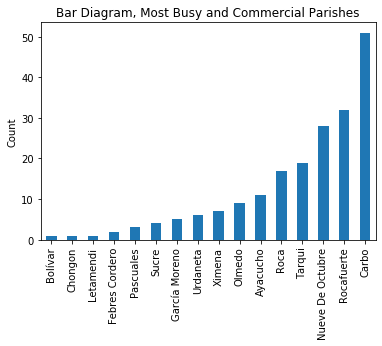

In [501]:
# type your answer here
Parish = getNearbyVenues(names=guayaquil_data['Parish'],latitudes=guayaquil_data['Latitude'],longitudes=guayaquil_data['Longitude'])
Agruped=Parish.groupby('Neighborhood').count()['Venue'].sort_values()
import matplotlib.pyplot as plt
Agruped.plot(kind='bar')
plt.title('Bar Diagram, Most Busy and Commercial Parishes')
plt.xlabel('')
plt.ylabel('Count')

#### The Pedro Carbo parish is considered downtown of Guayaquil, being in the middle of the tourist area, discotheque, and near the La ferris wheel of Guayaquil, The perla Of Pacifico, and Cerro Santana.

In [502]:
#Let's find out how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(guayaquil_venues['Venue Category'].unique())))

There are 73 uniques categories.


#### Let's explore the frequency of the most representative places by parish

In [503]:
# one hot encoding
guayaquil_onehot = pd.get_dummies(guayaquil_venues[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
guayaquil_onehot['Neighborhood'] = guayaquil_venues['Neighborhood'] 
# move neighborhood column to the first column
fixed_columns = [guayaquil_onehot.columns[-1]] + list(guayaquil_onehot.columns[:-1])
guayaquil_onehot = guayaquil_onehot[fixed_columns]
guayaquil_grouped = guayaquil_onehot.groupby('Neighborhood').mean().reset_index()
for hood in guayaquil_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = guayaquil_grouped[guayaquil_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Abel Gilbert, Batallón del Suburbio, Estero Salado, Febres Cordero.----
                 venue  freq
0  Pharmacy             0.5 
1  Gift Shop            0.5 
2  American Restaurant  0.0 
3  Movie Theater        0.0 
4  Pet Store            0.0 


----Acuarela, Comegua, Brisas del Rio, Limonal, Juan Pablo II, Alborada Este, Alborada Oeste, Bellavista----
                 venue  freq
0  Coffee Shop          0.11
1  Shopping Mall        0.11
2  American Restaurant  0.05
3  Café                 0.05
4  Pharmacy             0.05


----Ayacucho----
                venue  freq
0  Seafood Restaurant  0.36
1  Playground          0.09
2  Harbor / Marina     0.09
3  Restaurant          0.09
4  Park                0.09


----Bastión Popular, Las Orquídeas Este, Las Orquídeas Oeste, Los Vergeles----
                       venue  freq
0  South American Restaurant  0.33
1  Chinese Restaurant         0.33
2  Diner                      0.33
3  American Restaurant        0.00
4  Pizza Place        

#### Let's show a list of the 5 best known places by Neighborhood

In [504]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 5
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = guayaquil_grouped['Neighborhood']

for ind in np.arange(guayaquil_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(guayaquil_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Abel Gilbert, Batallón del Suburbio, Estero Salado, Febres Cordero.",Pharmacy,Gift Shop,Food Court,Dessert Shop,Diner
1,"Acuarela, Comegua, Brisas del Rio, Limonal, Juan Pablo II, Alborada Este, Alborada Oeste, Bellavista",Coffee Shop,Shopping Mall,American Restaurant,Burger Joint,Food Court
2,Ayacucho,Seafood Restaurant,Breakfast Spot,Playground,Restaurant,Fast Food Restaurant
3,"Bastión Popular, Las Orquídeas Este, Las Orquídeas Oeste, Los Vergeles",South American Restaurant,Diner,Chinese Restaurant,Food Truck,Falafel Restaurant
4,Bolívar (Sagrario),Market,Vegetarian / Vegan Restaurant,Food Truck,Diner,Falafel Restaurant


#### Now, let's explore all these characteristics by parish, and group these parishes by color, this analysis does not take into account the spatial distance, but the similar commercial characteristics between parishes


In [505]:
#Cluster Neighborhoods
# set number of clusters
from sklearn.cluster import KMeans
kclusters = 3
guayaquil_grouped_clustering = guayaquil_grouped.drop('Neighborhood', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(guayaquil_grouped_clustering)
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster', kmeans.labels_)
guayaquil_merged = df
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
guayaquil_merged = guayaquil_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 12 columns):
Postcode                 16 non-null object
Parish                   16 non-null object
Borough                  16 non-null object
Neighborhood             16 non-null object
Longitude                16 non-null object
Latitude                 16 non-null object
Cluster                  16 non-null int32
1st Most Common Venue    16 non-null object
2nd Most Common Venue    16 non-null object
3rd Most Common Venue    16 non-null object
4th Most Common Venue    16 non-null object
5th Most Common Venue    16 non-null object
dtypes: int32(1), object(11)
memory usage: 1.5+ KB


In [510]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(guayaquil_merged['Latitude'], guayaquil_merged['Longitude'], guayaquil_merged['Neighborhood'], guayaquil_merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
display(map_clusters)

TypeError: must be real number, not str